## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## 1. Camera calibration

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from collections import deque
%matplotlib inline
# or you can use 'qt'

def find_calib():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    nx = 9
    ny = 6

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        cornersarray = np.array(corners)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

            # Calculate calibration of camera  
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return ret, mtx, dist, rvecs, tvecs

ret, mtx, dist, rvecs, tvecs = find_calib()

## 2. Undistort, Threshold,  and perspective transform

In [2]:
# Convert to HLS color space and separate the S channel

from PIL import ImageFont
from PIL import ImageDraw 

def undistort(img, ret, mtx, dist ,rvecs, tvecs):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def thresholding(img):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

def perspectivetransform(img, topdown):
    offset=[150,0]
    corners = np.float32([[190,720],[589,457],[698,457],[1145,720]]) # bottom-left, top-left, top-right, bottom-right ([x,y])
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])    
    src = np.float32([corners[0], corners[1], corners[2], corners[3]])
    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    if topdown:
        M = cv2.getPerspectiveTransform(src, dst)        
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    img_size = img.shape
    warped = cv2.warpPerspective(img, M, (img_size[1], img_size[0]), flags=cv2.INTER_LINEAR)    
    return warped, M

def lanedimage(lane, undist):  
    downtop, new_M = perspectivetransform(lane, topdown=False)
    lanedimage = cv2.addWeighted(downtop, 0.5, undist, 1, 0.0)
    return lanedimage

## 3. Detect lines and create the line class

In [3]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = deque([], maxlen= 5)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        self.best_fit_x = np.array([])
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.allxy = None
        self.fit_yvals = np.linspace(0, 719, num=720)
        self.line_pos = None
        
    def detectlane(self, warped, left_or_right):
        window_width = 50 
        window_height = 80 # Break image into 9 vertical layers since image height is 720
        margin = 100 # How much to slide left and right for searching
        def window_mask(width, height, img_ref, center, level):
            output = np.zeros_like(img_ref)
            output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height), \
                   max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
            return output

        def find_window_centroids(warped, window_width, window_height, margin):
            window_centroids = [] # Store the (left,right) window centroid positions per level
            window = np.ones(window_width) # Create our window template that we will use for convolutions

            # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
            # and then np.convolve the vertical image slice with the window template 

            # Sum quarter bottom of image to get slice, could use a different ratio
            l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
            l_center = np.argmax(np.convolve(window,l_sum)) - window_width/2
            r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
            r_center = np.argmax(np.convolve(window,r_sum)) - window_width/2+int(warped.shape[1]/2)

            # Add what we found for the first layer
            window_centroids.append((l_center,r_center))

            # Go through each layer looking for max pixel locations
            for level in range(1, (int)(warped.shape[0]/window_height)):
                # convolve the window into the vertical slice of the image
                image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
                conv_signal = np.convolve(window, image_layer)
                # Find the best left centroid by using past left center as a reference
                # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
                offset = window_width/2
                l_min_index = int(max(l_center+offset-margin,0))
                l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
                l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
                # Find the best right centroid by using past right center as a reference
                r_min_index = int(max(r_center+offset-margin,0))
                r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
                r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
                # Add what we found for that layer
                window_centroids.append((l_center,r_center))

            return np.array(window_centroids)

        window_centroids = find_window_centroids(warped, window_width, window_height, margin)
        # If we found any window centers
        if len(window_centroids) > 0:

            self.detected = True

            # Points used to draw all the left and right windows
            l_points = np.zeros_like(warped)
            r_points = np.zeros_like(warped)

            # Go through each level and draw the windows 	
            for level in range(0,len(window_centroids)):
                # Window_mask is a function to draw window areas
                l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
                r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
                # Add graphic points from window mask here to total pixels found 
                l_points[(l_mask == 1)] = 255
                r_points[(r_mask == 1)] = 255
                                                                
            # Plotting

            ploty = np.linspace(0, 719, num=720)
            left_fit = np.polyfit(np.linspace(0, 719, num=9), window_centroids[::-1,0], 2)
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fit = np.polyfit(np.linspace(0, 719, num=9), window_centroids[::-1,1], 2)
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
            
          
            # Measuring curvature
            ym_per_pix = 30/720 # meters per pixel in y dimension
            xm_per_pix = 3.7/700 # meters per pixel in x dimension

            # Fit new polynomials to x,y in world space
            y_eval = warped.shape[0]
                                   
            left_fit_cr = np.polyfit(np.linspace(0, 719, num=9)*ym_per_pix, window_centroids[:,0]*xm_per_pix, 2)
            right_fit_cr = np.polyfit(np.linspace(0, 719, num=9)*ym_per_pix, window_centroids[:,1]*xm_per_pix, 2)
                           
            # Calculate the new radii of curvature
            left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
            right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
                        
            basepos = 640
            if (left_or_right == left):
                self.recent_xfitted.appendleft(left_fitx)
                self.bestx = np.mean(self.recent_xfitted, axis=0)
                self.best_fit = np.polyfit(self.fit_yvals, self.bestx, 2)
                self.best_fit_x = self.best_fit[0]*self.fit_yvals**2 + self.best_fit[1]*self.fit_yvals + self.best_fit[2]
                self.allxy = np.array(l_points)
                self.current_fit = left_fit
                self.radius_of_curvature = left_curverad
                self.line_pos = self.current_fit[0]*y_eval**2 +self.current_fit[1]*y_eval + self.current_fit[2]
                self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

            else:
                self.recent_xfitted.appendleft(right_fitx)
                self.bestx = np.mean(self.recent_xfitted, axis=0)
                self.best_fit = np.polyfit(self.fit_yvals, self.bestx, 2)
                self.best_fit_x = self.best_fit[0]*self.fit_yvals**2 + self.best_fit[1]*self.fit_yvals + self.best_fit[2]
                self.allxy = np.array(r_points)
                self.current_fit = right_fit
                self.radius_of_curvature = right_curverad
                self.line_pos = self.current_fit[0]*y_eval**2 +self.current_fit[1]*y_eval + self.current_fit[2]
                self.line_base_pos = (self.line_pos - basepos)*3.7/600.0 # 3.7 meters is about 600 pixels in the x direction

        # If no window centers found, just display orginal road image
        else:
            self.detected = False
            
        return self.detected       

## 4. Image process pipeline

In [4]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio

def pipeline(img):
    undist = undistort(img, ret, mtx, dist ,rvecs, tvecs)
    combined_binary = thresholding(undist)
    birdview, M = perspectivetransform(combined_binary, topdown = True)
    global left
    global right
    l_detected = left.detectlane(birdview, left_or_right = left)
    r_detected = right.detectlane(birdview, left_or_right = right)
    
    # Draw the results
    template = left.allxy + right.allxy # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = cv2.merge((zero_channel,template,zero_channel)) # make window pixels green
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, 719, num=720)
   
    pts_left = np.array([np.transpose(np.vstack([left.best_fit_x, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right.best_fit_x, ploty])))])
    pts = np.hstack(( pts_left, pts_right ))   
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))    

    template = template + color_warp
   
    warpage = np.array(cv2.merge((birdview,birdview,birdview)),np.uint8) # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    result = lanedimage(template, undist)
    
    #     
    # below from Udacity student ksakmann, https://github.com/ksakmann/CarND-Advanced-Lane-Lines/blob/master/stage2_video_pipeline.ipynb
    lane_width = 3.7
    off_center = -100*round(0.5*(right.line_base_pos-lane_width/2) +  0.5*(abs(left.line_base_pos)-lane_width/2),2)
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('distance from center: '+str(off_center)+'cm')
    cv2.putText(result,str1,(430,630), font, 1,(0,0,255),2,cv2.LINE_AA)
    if left.radius_of_curvature and right.radius_of_curvature:
        curvature = 0.5*(round(right.radius_of_curvature/1000,1) + round(left.radius_of_curvature/1000,1))
        str2 = str('radius of curvature: '+str(curvature)+'km')
        cv2.putText(result,str2,(430,670), font, 1,(0,0,255),2,cv2.LINE_AA)    
    # above from Udacity student ksakmann, https://github.com/ksakmann/CarND-Advanced-Lane-Lines/blob/master/stage2_video_pipeline.ipynb
    #
        
    return result

## 5. Single image processing

==================== ./test_images\straight_lines1.jpg ====================


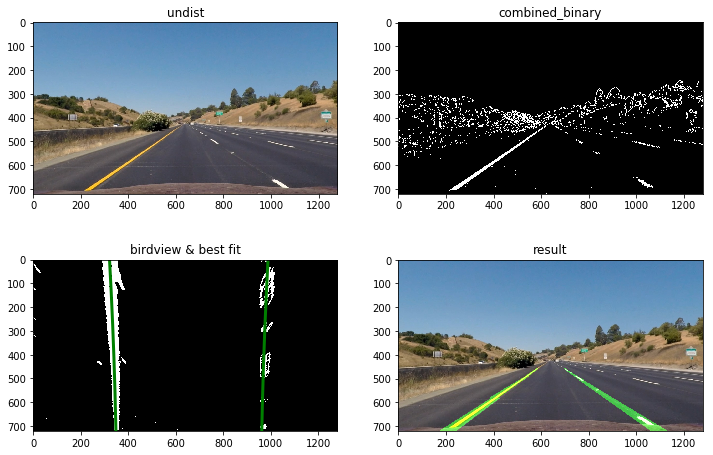

==================== ./test_images\straight_lines2.jpg ====================


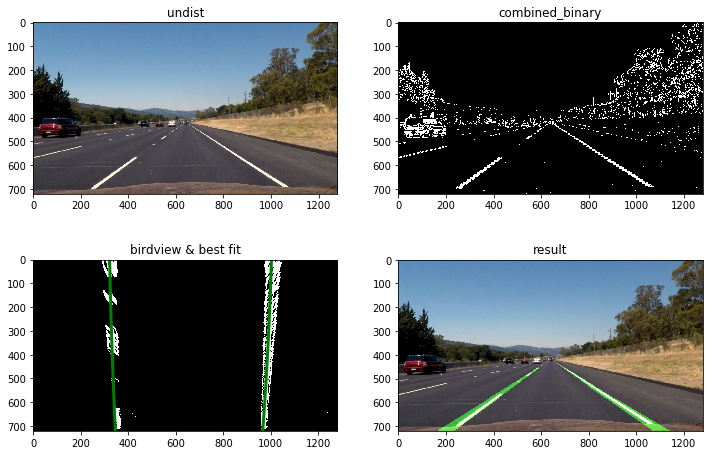

==================== ./test_images\test1.jpg ====================


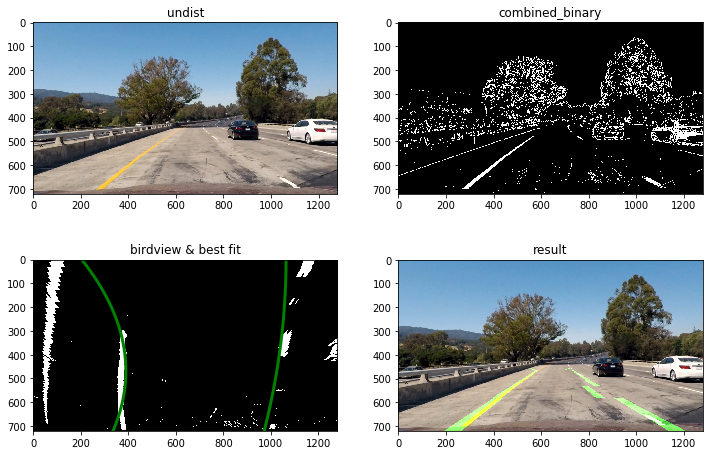

==================== ./test_images\test2.jpg ====================


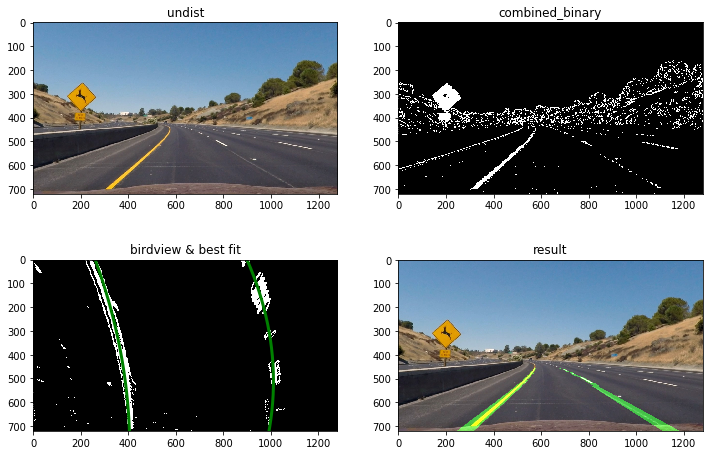

==================== ./test_images\test3.jpg ====================


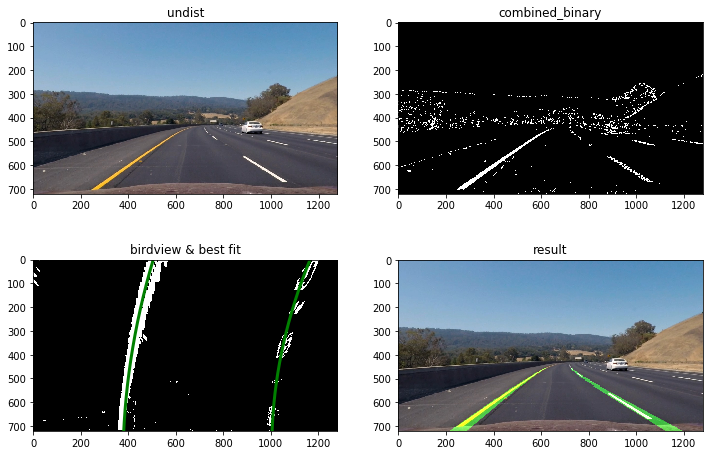

==================== ./test_images\test4.jpg ====================


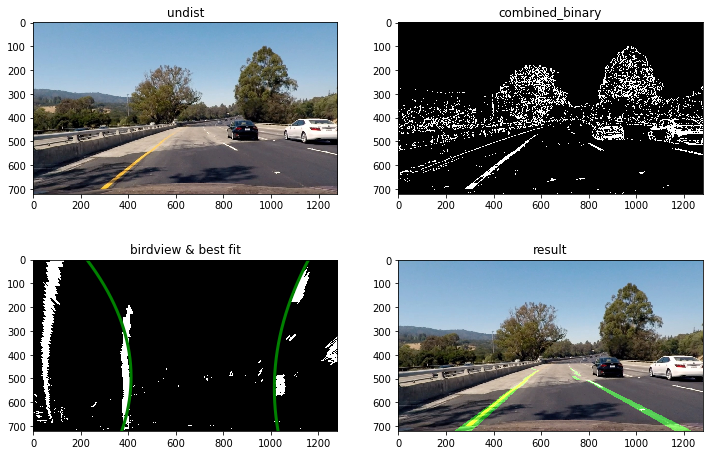

==================== ./test_images\test5.jpg ====================


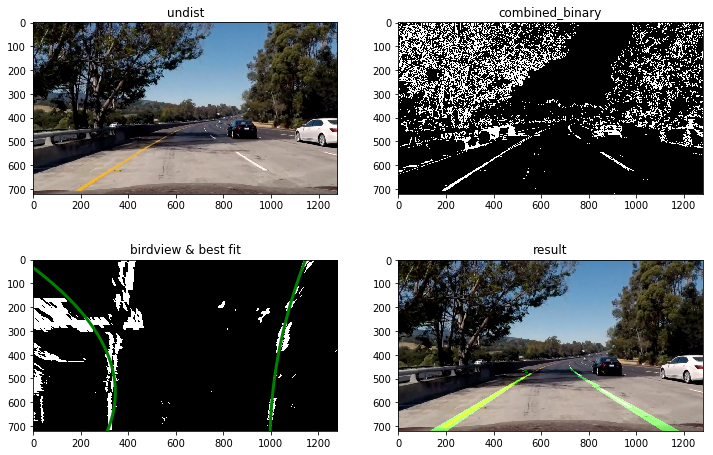

==================== ./test_images\test6.jpg ====================


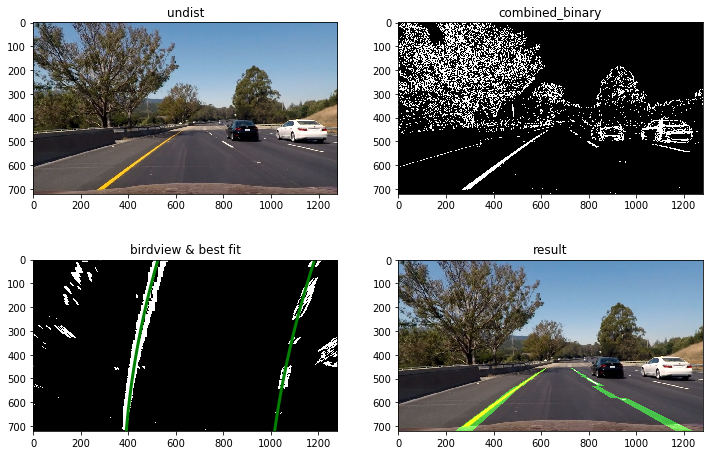

In [11]:
images = glob.glob('./test_images/*.jpg')
ploty = np.linspace(0, 719, num=720)
# fname = './test_images/straight_lines1.jpg' # for one image test
for fname in images:
    img = cv2.imread(fname)
    undist = undistort(img, ret, mtx, dist ,rvecs, tvecs)
    combined_binary = thresholding(undist)
    birdview, M = perspectivetransform(combined_binary, topdown = True)
    left = Line()
    right = Line()
    l_detected = left.detectlane(birdview, left_or_right = left)
    r_detected = right.detectlane(birdview, left_or_right = right)
    template = left.allxy + right.allxy # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = cv2.merge((zero_channel,template,zero_channel)) # make window pixels green 
    result = lanedimage(template, undist)

    print ("====================",fname, "====================")    
    fig = plt.figure(figsize = (12,8))
    plt.subplot(221)
    plt.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
    plt.title('undist')
    plt.subplot(222)
    plt.imshow(combined_binary, cmap ='gray')
    plt.title('combined_binary')
    plt.subplot(223)
    plt.imshow(birdview, cmap = 'gray')
    plt.title('birdview & best fit')
    plt.xlim(0, 1280)
    plt.ylim(0, 720)
    plt.plot(left.best_fit_x, ploty, color='green', linewidth=3)
    plt.plot(right.best_fit_x, ploty, color='green', linewidth=3)
    plt.gca().invert_yaxis() # to visualize as we do the images
    plt.subplot(224)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title('result')
    plt.show()

## 6. Vidoe processing

In [12]:
output_vid = 'output.mp4'

left = Line()
right = Line()
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./harder_video.mp4")
output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output_vid, audio=False)

# HTML("""
# <video width="1280" height="720" controls>
#   <source src="{0}">
# </video>
# """.format(output_vid))

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [08:05<00:00,  2.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

Wall time: 8min 9s
